
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [7]:
e

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

KeyboardInterrupt: 

We can ascertain the categories with `target_names` or the actual files with `filenames`

In [67]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [68]:
newsgroupsCategories = ['alt.atheism', 'sci.med', 'sci.space', 'soc.religion.christian']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: alt.atheism
Fetching data for: sci.med
Fetching data for: sci.space
Fetching data for: soc.religion.christian
2266


,category,source_file,text
0,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,"\n\nIdeologies also split, giving more to disa..."
1,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nI would rather be at a higher risk of bein...
2,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,"\nNope, Germany has extremely restrictive citi..."
3,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\n\n\nYup. I can hear the _millions_ cheeri...
4,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n(Deletion)\n \nNo it in the way it is usual...
5,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n: For all the problems technology has c...
6,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nDid I claim that there was an absolute mor...
7,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nI assume you are posting to encourage comm...
8,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,Thanks to whoever posted this wonderful parody...
9,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n More info please. I'm not well exposed to...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [69]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2266, 29804)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [70]:
newsgroupsVects

<2266x29804 sparse matrix of type '<class 'numpy.int64'>'
	with 250520 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [71]:
newsgroupsVects[:400,:500].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [72]:
ngCountVectorizer.vocabulary_.get('life')

16369

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [73]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2266, 29804)


This gives us the tf-idf for each word in each text

In [74]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('ideologies', 0.10963638253779373),
 ('also', 0.05878975508056786),
 ('split', 0.04745819870472114),
 ('giving', 0.037237745242211615),
 ('more', 0.03670065385236367),
 ('to', 0.19472405117640135),
 ('disagree', 0.03940144456685191),
 ('upon', 0.03255460169440627),
 ('and', 0.07899639979474819),
 ('may', 0.043206362816087265),
 ('lead', 0.03648932462428196),
 ('intolerance', 0.054818191268896865),
 ('so', 0.016798475282207865),
 ('do', 0.032384309953472294),
 ('you', 0.05248122727838734),
 ('oppose', 0.04947910493837773),
 ('all', 0.06610660787116843),
 ('don', 0.018163099953066978),
 ('think', 0.076116666211079),
 ('your', 0.0372799741839986)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [75]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [76]:
newsgroupsDF['text']

0       \n\nIdeologies also split, giving more to disa...
1       \n\nI would rather be at a higher risk of bein...
2       \nNope, Germany has extremely restrictive citi...
3       \n\n\n\nYup.  I can hear the _millions_ cheeri...
4        \n(Deletion)\n \nNo it in the way it is usual...
5       \n:      For all the problems technology has c...
6       \n\nDid I claim that there was an absolute mor...
7       \n\nI assume you are posting to encourage comm...
8       Thanks to whoever posted this wonderful parody...
9       \n  More info please.  I'm not well exposed to...
10      \n\n Could you explain what any of the above p...
11      \n\nI did not claim that our system was object...
12      \n[my previous posting deleted]\n\n\nThe poste...
13      \n\nSo, we should ban the ammunition?  Why not...
14      \nMy own personal and highly subjective opinio...
15        ...\n\nI think this is a big leap sex->depre...
16      My point is that you set up your views as the ...
17      \n\n\t

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [77]:
try:
    print(ngTFVectorizer.vocabulary_['black'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

129


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [78]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [79]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [80]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [81]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [82]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,"\n\nIdeologies also split, giving more to disa...",2
1,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nI would rather be at a higher risk of bein...,1
2,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,"\nNope, Germany has extremely restrictive citi...",1
3,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\n\n\nYup. I can hear the _millions_ cheeri...,1
4,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n(Deletion)\n \nNo it in the way it is usual...,2
5,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n: For all the problems technology has c...,1
6,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nDid I claim that there was an absolute mor...,1
7,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nI assume you are posting to encourage comm...,2
8,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,Thanks to whoever posted this wonderful parody...,1
9,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n More info please. I'm not well exposed to...,1


We can also look at the distinguishing features in each cluster:

In [83]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 geb
 cadre
 shameful
 dsl
 pitt
 chastity
 n3jxp
 surrender
 intellect
 banks


Cluster 1:
 don
 people
 like
 just
 know
 think
 time
 does
 good
 thanks


Cluster 2:
 god
 jesus
 believe
 people
 faith
 bible
 church
 christ
 does
 christians


Cluster 3:
 space
 nasa
 launch
 shuttle
 orbit
 moon
 data
 lunar
 earth
 station




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [84]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [85]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [86]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

KeyError: 'alt.atheism'

Let's plot the data using the true labels as the colors of our data points.

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [87]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

KeyError: 'sci.space'

NameError: name 'colors_p' is not defined

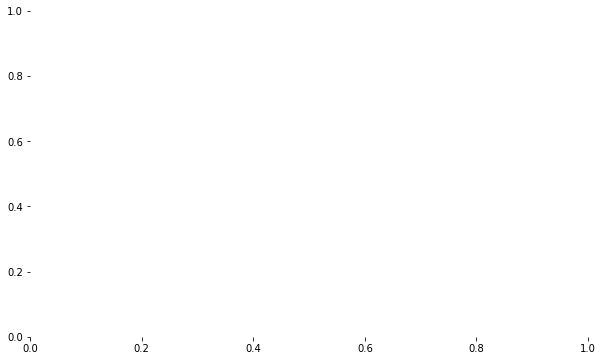

In [88]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [89]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [90]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

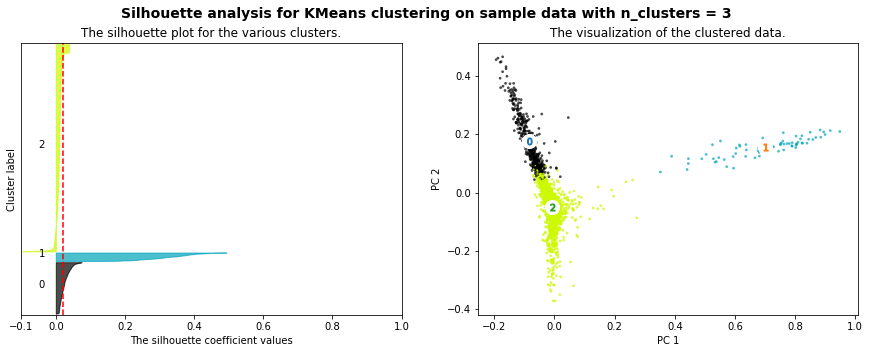

For n_clusters = 3, The average silhouette_score is : 0.022


In [91]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

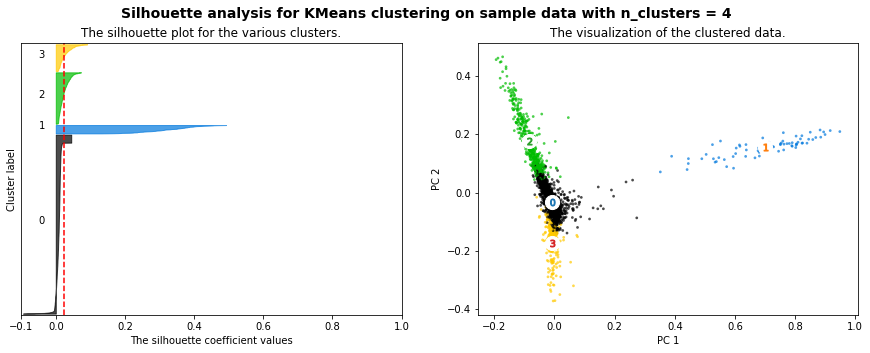

For n_clusters = 4, The average silhouette_score is : 0.023


In [92]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

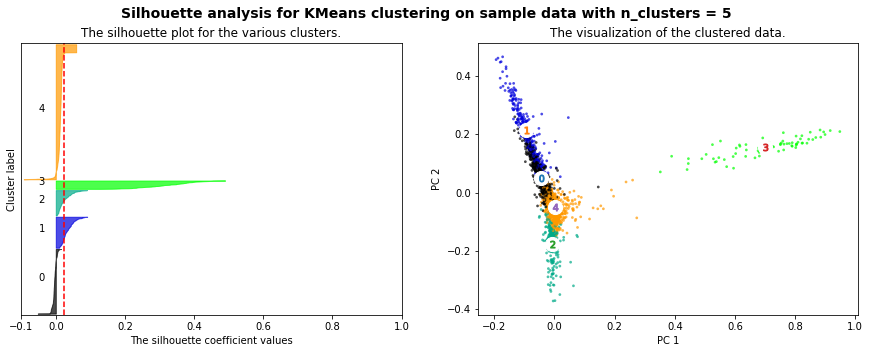

For n_clusters = 5, The average silhouette_score is : 0.023


In [93]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

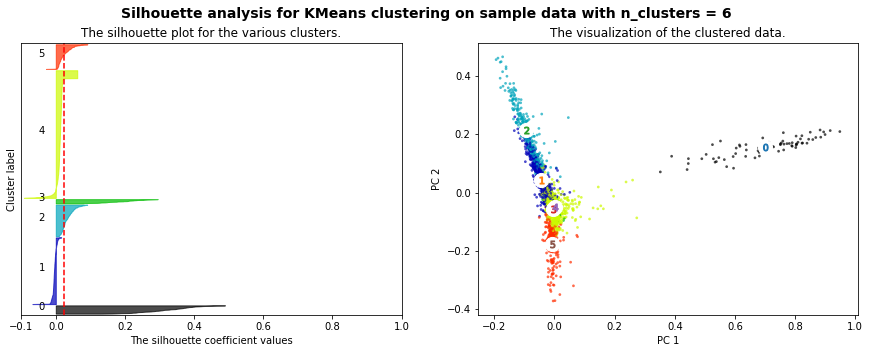

For n_clusters = 6, The average silhouette_score is : 0.025


In [94]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [95]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [96]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')
#conrad_df.dropna(axis=0, how='any')

In [97]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [98]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [99]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [100]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [101]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

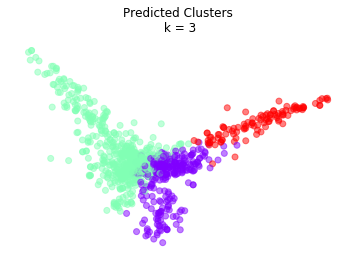

In [102]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [103]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,1
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [10]:
#loads dataframe
plos_df = pd.read_pickle(r'C:\Users\Timot\Documents\content-analysis-2018\data\plos_analysis\plos_sample.pk1')
#plos_df

In [14]:
#This turns documents into word count vectors.
#The question is whether or not to use the raw words, or to use the tokenized words, or the stemmed words. 
#First it needs to be initialized
plosCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
plosVects = plosCountVectorizer.fit_transform(plos_df['Article Contents'])
print(plosVects.shape)

(1000, 85406)


In [17]:
#this allows for the use of tf-idf, which allows for document distinguishing, while excluding highly frequent words which are less meaningful in distinguishing between documents
#initialize
plosTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(plosVects)
#train
plosTF = plosTFTransformer.transform(plosVects)
print(plosTF.shape)

(1000, 85406)


In [18]:
#gives the tf-idf of each word
list(zip(plosCountVectorizer.vocabulary_.keys(), plosTF.data))[:10]
#for the values given for each word, the smaller the value the less informative that word is in the corpus, informative to what specifically I think is the ability to distinguish different documetns. 

[('the', 0.28064071392140805),
 ('study', 0.012036481335028035),
 ('of', 0.28742672458939356),
 ('animal', 0.0224640006872007),
 ('communication', 0.03735841890349157),
 ('is', 0.06666142334010972),
 ('complex', 0.006242023903057537),
 ('science', 0.010829491505036136),
 ('addressing', 0.014011877749229443),
 ('wide', 0.007561986280061522)]

In [21]:
#This 'prunes' the matrix, meaning it only leaves certain words based upon frequency and weighting, I think. 
#initialize
plosTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
plosTFVects = plosTFVectorizer.fit_transform(plos_df['Article Contents'])

In [22]:
plosVects

<1000x85406 sparse matrix of type '<class 'numpy.int64'>'
	with 1092777 stored elements in Compressed Sparse Row format>

In [23]:
#comparing this and the above cell it is easy to see what the tf-idf pruning is doing. It is limiting what words are going to be analyzed by their weights.
#Now there are 1000 words but the same amount of documents. 
plosTFVects

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 261095 stored elements in Compressed Sparse Row format>

In [24]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(plosTFVects.toarray())
reduced_data = pca.transform(plosTFVects.toarray())

Before doing any clustering it is first necessary to look at what number of clusters would be appropriate for the data and this requires using what is called the silhouette method, which is a method for measuring how well a piece of data fits into a cluster. The method will produce a score from -1 to +1 with higher values meaning a higher level of fit and lower less fit. 

In [25]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

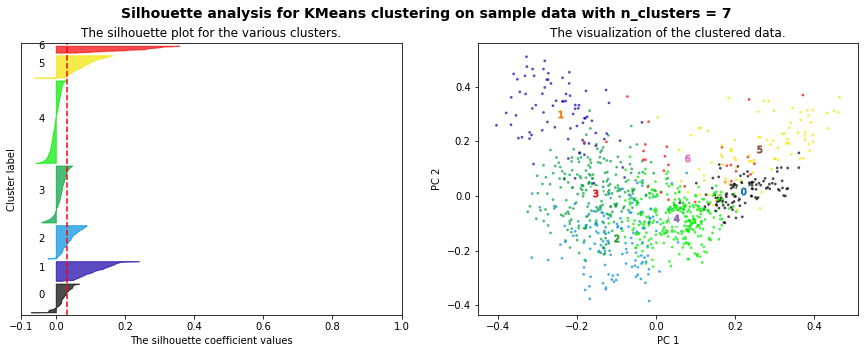

For n_clusters = 7, The average silhouette_score is : 0.032


In [26]:
X = plosTFVects.toarray()
plotSilhouette(7, X)

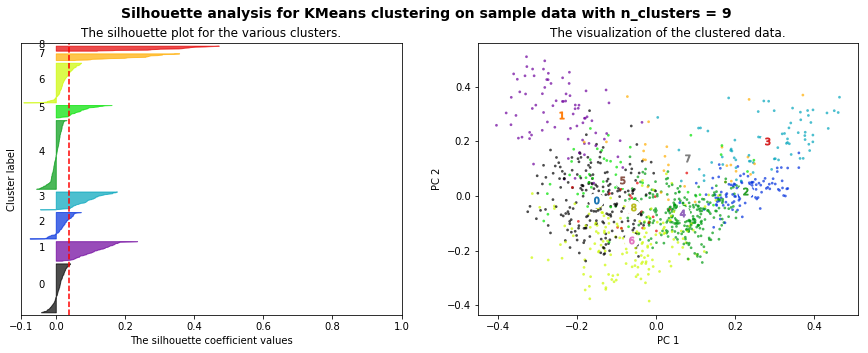

For n_clusters = 9, The average silhouette_score is : 0.039


In [27]:
X = plosTFVects.toarray()
plotSilhouette(9, X)

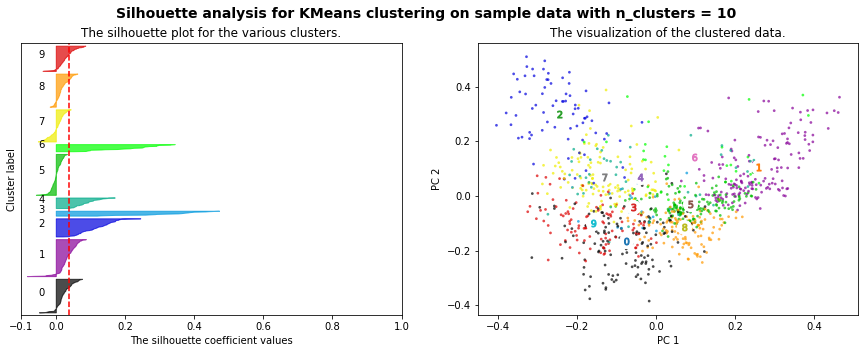

For n_clusters = 10, The average silhouette_score is : 0.040


In [28]:
X = plosTFVects.toarray()
plotSilhouette(10, X)

In [32]:
print(plosTFVectorizer.vocabulary_)

{'animal': 78, 'complex': 190, 'wide': 984, 'signal': 836, 'sensitivity': 819, 'course': 223, 'signaling': 837, 'selection': 815, 'wild': 985, 'degree': 249, 'quality': 732, 'stable': 862, 'early': 294, 'work': 987, 'suggested': 898, 'status': 870, 'cut': 234, 'outcome': 630, 'subsequent': 894, 'social': 851, 'absence': 44, 'sufficient': 897, 'ability': 42, 'lack': 488, 'green': 397, 'species': 857, 'ca': 135, 'nm': 608, 'investigated': 474, '90': 39, 'component': 192, 'shape': 832, 'particular': 645, 'males': 529, 'signals': 838, 'male': 528, 'power': 692, 'core': 217, 'areas': 93, 'characteristics': 156, 'instead': 462, 'proportion': 723, 'body': 127, 'parameters': 641, 'field': 351, 'laboratory': 487, 'contribute': 214, 'smaller': 848, 'experimental': 331, 'area': 92, 'confirmed': 202, 'recently': 750, 'peak': 656, 'populations': 685, 'designed': 257, 'experiment': 330, 'note': 613, 'reduction': 757, 'days': 244, 'equal': 314, 'population': 684, '58': 26, 'follows': 363, 'establishe

In [33]:
#similar as to what was done above this allows us to see what a words indices are in the matrix, but thematrix is so much smaller now that the value given will be much smaller than the possible ones above. 
try:
    print(plosTFVectorizer.vocabulary_['risk'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(plosTFVectorizer.vocabulary_.keys())[:20]))

796


In [42]:
#similar as to what was done above this allows us to see what a words indices are in the matrix, but thematrix is so much smaller now that the value given will be much smaller than the possible ones above. 
try:
    print(plosTFVectorizer.vocabulary_['experimental'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(plosTFVectorizer.vocabulary_.keys())[:]))

331


The first method I am going to work with requires that I set the number of clusters that the documents can fit into. In the homework example this was reasonable because the documents were drawn from a particular set of pre-existing categories based on topic. For my corpus and the sake of this exercise I will use the same number of clusters as the homework example, this might be mathodolgically unsond or meaningless. Hopefully there is an unsupervised method which will allow a natural number of clusters to arise. 

In [43]:
numClusters = 9

In [44]:
#initaalizes cluster finder
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [45]:
#this calculates the clusters
km.fit(plosTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
#This evaluates the calculated clusters using 4 metrics, 

print("Evaluating Clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(plos_df['Journal Title'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(plos_df['Journal Title'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(plos_df['Journal Title'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(plos_df['Journal Title'], km.labels_)))
#I dont' think that any of these values actually mean anything because the numebr of clsuters I picked has no real meaning. And where plos_df['Journal Title] is above can be several different things and I don't know which is the most appropriate.

Evaluating Clusters:
Homogeneity: 0.114
Completeness: 0.045
V-measure: 0.065
Adjusted Rand Score: 0.006


In [47]:
#assigns cluster predictions to dataframe. But I don't think this method actually makes any sense becaue my choice of number of clusters is meaningless.
plos_df['kmeans_predictions'] = km.labels_
plos_df

,Article Contents,Copyright Year,Journal Title,Titles,kmeans_predictions
0,The study of animal communication is a complex...,2011,plos one,UV-Deprived Coloration Reduces Success in Mate...,4
1,Aneurysms in general represent a Damocles swor...,2017,plos one,Metabolomic profiling of ascending thoracic ao...,2
2,Prognostic information about life expectancy i...,2013,plos one,Predictive Value of a Profile of Routine Blood...,1
3,Interleukin (IL)-23 has been associated with t...,2017,plos one,Continuous IL-23 stimulation drives ILC3 deple...,3
4,Labor represents a stress test for the fetus. ...,2014,plos one,Assessment of Coupling between Trans-Abdominal...,4
5,Competition has long been recognized as a crit...,2014,plos one,Seaweed-Coral Interactions: Variance in Seawee...,4
6,There were errors in the legend of Figure 11. ...,2012,plos one,Correction: The Zinc Dyshomeostasis Hypothesis...,4
7,Phylogeographic studies leverage spatial and g...,2017,plos biology,A latitudinal phylogeographic diversity gradie...,4
8,Insulin-like Growth Factor-1 (IGF-1) is a pote...,2012,plos one,E-Peptides Control Bioavailability of IGF-1,5
9,Despite the expansive development of targeted ...,2014,plos one,Advancements in the Development of HIF-1α-Acti...,6


In [48]:
#Allows for inspecting the distinguishing features of each cluster
terms = plosTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 mir
 mirnas
 mirna
 heart
 gene
 genes
 rna
 cancer
 p53
 rats


Cluster 1:
 women
 risk
 age
 participants
 health
 children
 population
 snps
 bmi
 years


Cluster 2:
 patients
 patient
 clinical
 risk
 disease
 hospital
 ci
 serum
 age
 mortality


Cluster 3:
 mice
 wt
 il
 mouse
 ko
 infected
 anti
 infection
 animals
 wild


Cluster 4:
 species
 error
 spatial
 neurons
 area
 network
 section
 areas
 brain
 stimulus


Cluster 5:
 ml
 treated
 anti
 cancer
 il
 tumor
 µm
 nm
 induced
 growth


Cluster 6:
 dna
 sequences
 sequence
 proteins
 residues
 binding
 strains
 isolates
 domain
 plants


Cluster 7:
 genes
 gene
 reads
 rna
 proteins
 genome
 sequences
 regulated
 transcripts
 mutant


Cluster 8:
 hiv
 cd4
 infection
 infected
 vaccine
 virus
 viral
 women
 patients
 sex




In [55]:
#initaalizes cluster finder
Affinity = sklearn.cluster.AffinityPropagation()

In [62]:
Affinity.fit(plosTFVects)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [63]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

In [64]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

In [67]:
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [104]:
newsgroupsTFVects

<2266x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 72547 stored elements in Compressed Sparse Row format>

In [105]:
newsgroupsTFVects[:100].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [107]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [108]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [109]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 18.        ,  40.        ,   0.        ,   2.        ],
       [ 72.        , 200.        ,   0.        ,   3.        ],
       [ 79.        , 201.        ,   0.        ,   4.        ],
       [ 89.        , 202.        ,   0.        ,   5.        ],
       [122.        , 203.        ,   0.        ,   6.        ],
       [133.        , 204.        ,   0.        ,   7.        ],
       [184.        , 205.        ,   0.        ,   8.        ],
       [198.        , 206.        ,   0.        ,   9.        ],
       [ 98.        , 136.        ,   0.46942488,   2.        ],
       [ 51.        ,  96.        ,   0.47573995,   2.        ]])

Now we can visualize the tree

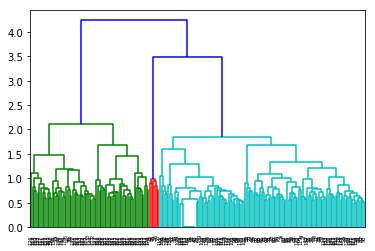

In [110]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

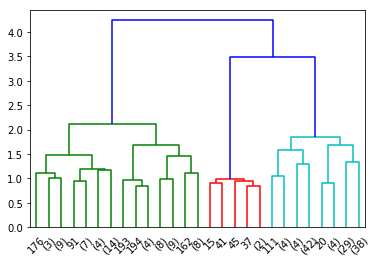

In [111]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [112]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 1, 4, 1, 3, 4, 4, 4, 1, 4, 4, 1, 4, 3, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 3, 4, 4, 4, 3, 4, 4,
       4, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 1, 4, 2, 4, 4,
       4, 4, 1, 1, 1, 4, 1, 1, 4, 4, 1, 4, 4, 4, 4, 2, 1, 1, 4, 4, 1, 4,
       1, 4, 4, 4, 4, 4, 1, 2, 4, 2, 1, 1, 1, 1, 4, 1, 1, 2, 2, 2, 2, 1,
       4, 2, 2, 1, 2, 4, 4, 2, 2, 1, 1, 4, 2, 2, 2, 1, 4, 1, 4, 2, 1, 2,
       1, 4, 2, 2, 2, 2, 4, 2, 4, 4, 1, 4, 4, 1, 1, 2, 2, 2, 2, 2, 4, 2,
       4, 2], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [113]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.195
Completeness: 0.238
V-measure: 0.214
Adjusted Rand Score: 0.157


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [114]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,kmeans_predictions,wald_predictions
0,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,"\n\nIdeologies also split, giving more to disa...",2,2
1,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nI would rather be at a higher risk of bein...,1,4
2,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,"\nNope, Germany has extremely restrictive citi...",1,4
3,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\n\n\nYup. I can hear the _millions_ cheeri...,1,4
4,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n(Deletion)\n \nNo it in the way it is usual...,2,2
5,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n: For all the problems technology has c...,1,3
6,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nDid I claim that there was an absolute mor...,1,3
7,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n\nI assume you are posting to encourage comm...,2,2
8,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,Thanks to whoever posted this wonderful parody...,1,4
9,alt.atheism,../data/scikit_learn_data/20news_home/20news-b...,\n More info please. I'm not well exposed to...,1,3


# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [115]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

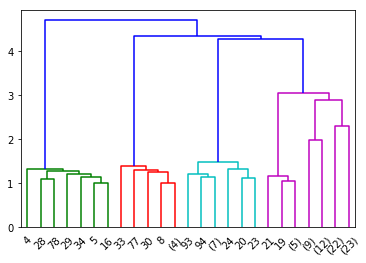

In [116]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [117]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

In [35]:
plosTFVects[:100].todense()

matrix([[0.        , 0.15644864, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.26894354,
         0.03860772],
        [0.        , 0.        , 0.02823103, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.02022338, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.01118371, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.20236336, ..., 0.        , 0.        ,
         0.        ]])

In [36]:
plosCoocMat = plosTFVects * plosTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
plosCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

ploslinkage_matrix = scipy.cluster.hierarchy.ward(plosCoocMat[:100, :100].toarray())

C:\Users\Timot\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
C:\Users\Timot\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


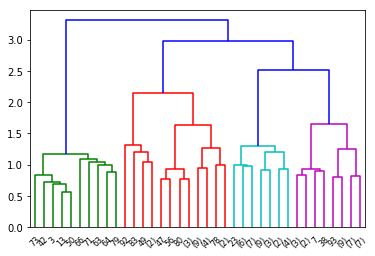

In [37]:
ax = scipy.cluster.hierarchy.dendrogram(ploslinkage_matrix, p=5, truncate_mode='level')

In [38]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(ploslinkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 2, 2, 1, 4, 4, 4, 4, 3, 3, 2, 4, 3, 1, 3, 4, 4, 2, 3, 2, 2, 4,
       2, 3, 4, 3, 4, 3, 4, 4, 2, 3, 3, 4, 4, 2, 3, 3, 4, 2, 2, 3, 1, 3,
       3, 3, 3, 2, 4, 2, 1, 3, 2, 2, 4, 3, 2, 3, 2, 3, 4, 3, 4, 1, 1, 3,
       1, 4, 3, 3, 2, 1, 2, 1, 3, 2, 3, 3, 2, 1, 2, 4, 4, 2, 4, 4, 2, 3,
       3, 3, 4, 4, 2, 4, 4, 4, 4, 3, 2, 2], dtype=int32)

In [39]:
ploslinkage_matrix_full = scipy.cluster.hierarchy.ward(plosCoocMat.toarray())
plos_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(ploslinkage_matrix_full, 4, 'maxclust')

C:\Users\Timot\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [40]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(plosCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(ploslinkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(plos_df['Journal Title'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(plos_df['Journal Title'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(plos_df['Journal Title'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(plos_df['Journal Title'], hierarchicalClusters_full)))

C:\Users\Timot\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.061
Completeness: 0.040
V-measure: 0.049
Adjusted Rand Score: 0.012


In [41]:
#This second method is affinity propogation 
sklearn.cluster.AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity=’euclidean’, verbose=False)

SyntaxError: invalid character in identifier (<ipython-input-41-4264b6e319a2>, line 2)

In [69]:
from collections import Counter


years = plos_df['Journal Title']

Counter(years).keys() # equals to list(set(words))
Counter(years).values() # counts the elements' frequency

dict_values([825, 20, 30, 32, 29, 31, 23, 10])

In [71]:
set(years)

{'none',
 'plos biology',
 'plos computational biology',
 'plos genetics',
 'plos medicine',
 'plos neglected tropical diseases',
 'plos one',
 'plos pathogens'}

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [118]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [119]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [120]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [121]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [122]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [123]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [124]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(3, 0.969056)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

First we can visualize as a stacked bar chart:

In [ ]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [ ]:
senlda.show_topic(1)

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

In [ ]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [75]:
#loads dataframe
plos_df = pd.read_pickle(r'C:\Users\Timot\Documents\content-analysis-2018\data\plos_analysis\plos_normalized_sample.pk1')
#plos_df

In [76]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

plos_df['reduced_tokens'] = plos_df['normalized_tokens'].apply(lambda x: dropMissing(x, plosTFVectorizer.vocabulary_.keys()))

In [77]:
dictionary = gensim.corpora.Dictionary(plos_df['reduced_tokens'])

In [78]:
corpus = [dictionary.doc2bow(text) for text in plos_df['reduced_tokens']]

In [79]:
gensim.corpora.MmCorpus.serialize('plos.mm', corpus)
senmm = gensim.corpora.MmCorpus('plos.mm')

In [80]:
ploslda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [81]:
plos1Bow = dictionary.doc2bow(plos_df['reduced_tokens'][2])
plos1lda = ploslda[plos1Bow]
print("The topics of the text: {}".format(plos_df['Titles'][2]))
print("are: {}".format(plos1lda))

The topics of the text: Predictive Value of a Profile of Routine Blood Measurements on Mortality in Older Persons in the General Population: The Leiden 85-Plus Study
are: [(2, 0.5070437), (6, 0.010039374), (8, 0.47917867)]


In [82]:
ldaDF = pandas.DataFrame({
        'Title' : plos_df['Titles'],
        'topics' : [ploslda[dictionary.doc2bow(l)] for l in plos_df['reduced_tokens']]
    })

In [83]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(ploslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(ploslda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,Title,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,Metabolomic profiling of ascending thoracic ao...,"[(1, 0.70996106), (2, 0.031127702), (7, 0.1141...",0.000000,0.709961,0.031128,0.000000,0.000000,0.000000,0.000000,0.114186,0.139819,0.000000
101,Investigation of correlates of protection agai...,"[(2, 0.02320127), (4, 0.122135974), (5, 0.0206...",0.000000,0.000000,0.023201,0.000000,0.122136,0.020657,0.000000,0.000000,0.316166,0.515296
201,A New Method for Morphometric Analysis of Tiss...,"[(0, 0.46087733), (1, 0.25122926), (7, 0.28518...",0.460877,0.251229,0.000000,0.000000,0.000000,0.000000,0.000000,0.285183,0.000000,0.000000
301,Multinational Tagging Efforts Illustrate Regio...,"[(0, 0.81912714), (1, 0.17815407)]",0.819127,0.178154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
401,Brain Serotonin Signaling Does Not Determine S...,"[(0, 0.8822507), (5, 0.116045624)]",0.882251,0.000000,0.000000,0.000000,0.000000,0.116046,0.000000,0.000000,0.000000,0.000000
501,Osmostress Induces Autophosphorylation of Hog1...,"[(0, 0.21103391), (5, 0.016963834), (6, 0.0518...",0.211034,0.000000,0.000000,0.000000,0.000000,0.016964,0.051886,0.045904,0.000000,0.672595
601,"Feasibility, Acceptability, and Potential Effe...","[(2, 0.9247832), (9, 0.069717504)]",0.000000,0.000000,0.924783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069718
701,Adolescent Abstinence and Unprotected Sex in C...,"[(2, 0.7981791), (3, 0.03088715), (4, 0.169351...",0.000000,0.000000,0.798179,0.030887,0.169352,0.000000,0.000000,0.000000,0.000000,0.000000
801,Polymorphism in the Serotonin Receptor 2a (HTR...,"[(0, 0.08861664), (2, 0.19189444), (3, 0.14322...",0.088617,0.000000,0.191894,0.143227,0.000000,0.000000,0.460949,0.000000,0.000000,0.103854
901,Predicting Cognitive Function from Clinical Me...,"[(1, 0.086749375), (2, 0.46738023), (9, 0.4423...",0.000000,0.086749,0.467380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.442380


In [84]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['Title']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.845146,0.000000,0.000000,0.148700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.709961,0.031128,0.000000,0.000000,0.000000,0.000000,0.114186,0.139819,0.000000
2,0.000000,0.000000,0.516673,0.000000,0.000000,0.000000,0.011465,0.000000,0.468123,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.124506,0.872577,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.383821,0.470501,0.000000,0.000000,0.065807,0.000000,0.000000,0.070040
5,0.533174,0.000000,0.068923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.395747
6,0.000000,0.596125,0.000000,0.000000,0.000000,0.373981,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.310141,0.000000,0.000000,0.000000,0.000000,0.018796,0.000000,0.000000,0.668101
8,0.078105,0.000000,0.000000,0.000000,0.207154,0.135089,0.000000,0.577737,0.000000,0.000000
9,0.284953,0.000000,0.000000,0.027157,0.051624,0.000000,0.000000,0.610887,0.000000,0.024165


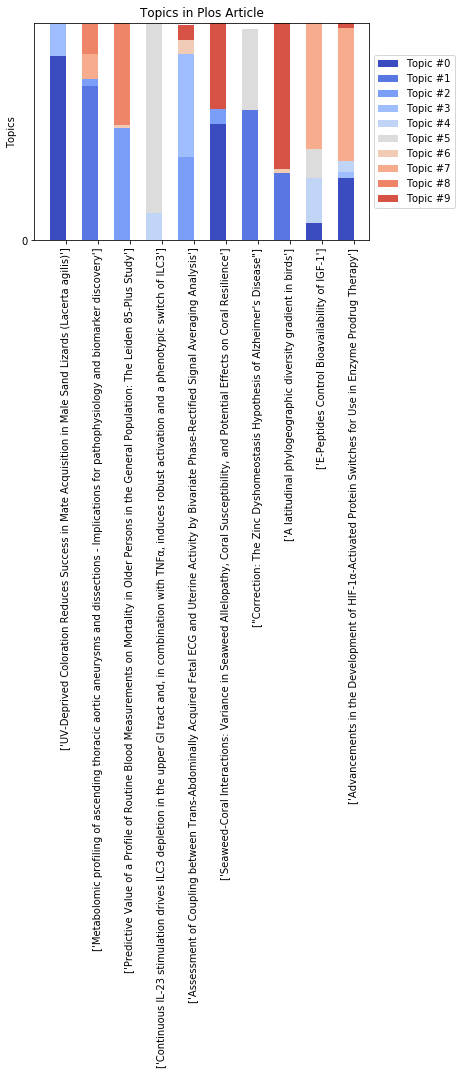

In [85]:
N = 10
ind = np.arange(N)
K = ploslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Plos Article')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [94]:
ploslda.show_topic(0)

[('gene', 0.020754838),
 ('mice', 0.018252661),
 ('ha', 0.017804518),
 ('area', 0.017491251),
 ('site', 0.016782736),
 ('differ', 0.01561001),
 ('day', 0.012876449),
 ('network', 0.011783655),
 ('acid', 0.010942484),
 ('base', 0.010767855)]

In [87]:
topicsDict = {}
for topicNum in range(ploslda.num_topics):
    topicWords = [w for w, p in ploslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,gene,differ,differ,differ,differ,mice,snp,gene,gene,differ
1,mice,age,women,gene,follow,patient,differ,differ,patient,ha
2,ha,region,ha,signal,mice,differ,gene,patient,differ,age
3,area,site,report,cancer,product,day,patient,ha,obtain,mice
4,site,ha,gene,pathway,gene,gene,ha,dna,transcript,gene
5,differ,report,day,report,report,ha,region,follow,ha,report
6,day,base,age,ha,health,follow,report,day,report,domain
7,network,detect,patient,mirna,detect,report,age,mice,age,children
8,acid,form,mice,develop,extract,strain,cost,mutant,sleep,year
9,base,process,year,region,ha,network,respect,detect,base,area


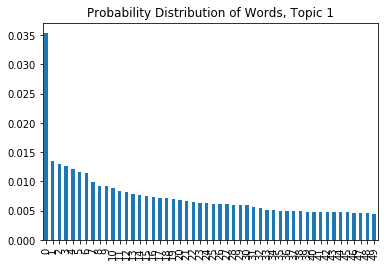

In [88]:
topic1_df = pandas.DataFrame(ploslda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [89]:
ploslda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
ploslda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

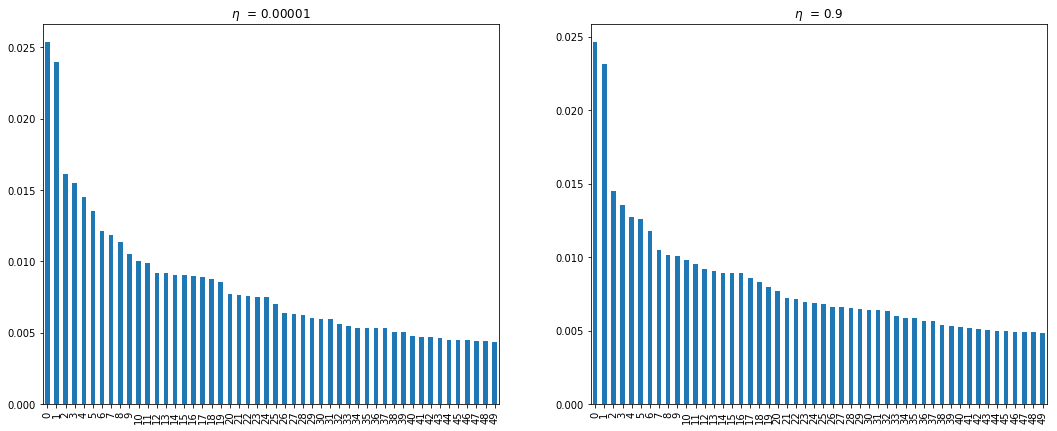

In [90]:
topic11_df = pandas.DataFrame(ploslda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(ploslda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

Below is code relevant to the Affinity Propogation method of clustering. Need to figure out how to apply it to my data. 

In [95]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs


In [101]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

In [102]:
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))


Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


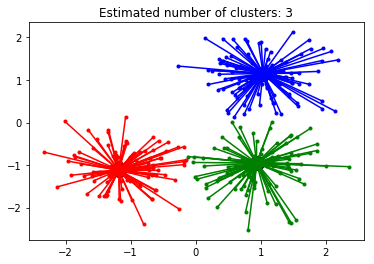

In [98]:
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()